## Load Packages

In [1]:
using Distributions

#using Dates            #Julia 0.7
using Compat, Missings  #to use 0.7 syntax in 0.6

include("printmat.jl")

printlnPs (generic function with 2 methods)

In [2]:
using Plots
backend = "gr"              #"gr" (default), "pyplot" 

if backend == "pyplot"
    pyplot(size=(600,400))
else    
    gr(size=(600,400))
end

Plots.GRBackend()

# Long-Run Returns as a Sum of Short-Run Returns

Let $R_{t}$ be a one-period net return. 
It is sometimes convenient to approximate the $q$-period return $Z_{q}$ as

$
Z_{q}    =(R_{1}+1)(R_{2}+1)\ldots(R_{q}+1)-1
$

This is sometimes approximated by 

$
Z_{q}   \approx R_{1}+R_{2}+\ldots+R_{q}. 
$

However, log returns $r=\ln (1+R)$ are better suited for multi-period analysis since there is no approximation error in

$z_{q}=r_{1}+r_{2}+\ldots+r_{q}$

In [3]:
R_A = [5;-5;5]/100            #net returns portfolio A in three periods
R_B = [20;-35;25]/100

r_A = log.(1.0.+R_A)             #log returns
r_B = log.(1.0.+R_B)   

Price_A = [1;cumprod(1.0.+R_A)]     #price of portfolio A, assuming price in t=0 is 1.0
Price_B = [1;cumprod(1.0.+R_B)]

TotRet_A = Price_A[end]/Price_A[1] - 1
TotRet_B = Price_B[end]/Price_B[1] - 1

println("time      Price_A      Price_B")
printmat([(0:3) Price_A Price_B])

println("Total net returns: A and B, in %")
printmat([TotRet_A TotRet_B]*100)

println("Average net returns: A and B, in %")
printmat(mean([R_A R_B],1)*100)

println("Average log returns: A and B, in %")
printmat(mean([r_A r_B],1)*100)

time      Price_A      Price_B
     0.000     1.000     1.000
     1.000     1.050     1.200
     2.000     0.997     0.780
     3.000     1.047     0.975

Total net returns: A and B, in %
     4.737    -2.500

Average net returns: A and B, in %
     1.667     3.333

Average log returns: A and B, in %
     1.543    -0.844



# Distribution of Long-Run Returns in the iid Case

If $r$ is iid N$(\mu,\sigma^2)$, then $z_q$ is N$(q\mu,q\sigma^2)$. 

In [4]:
function ΦNS(x,μ=0,σ²=1)                          #cdf of N(μ,σ²), NS for "non-standard"
    Pr = cdf(Normal(μ,sqrt(σ²)),x)
  return Pr
end

function ϕNS(x,μ=0,σ²=1)              #pdf of N(μ,σ²), NS for "non-standard"
    pdfx = pdf(Normal(μ,sqrt(σ²)),x)
    return pdfx
end

ϕNS (generic function with 3 methods)

## Pdfs of Long-Run Returns (for Different Horizons)

In [5]:
Z = linspace(-50,100,101)
#Z = range(-50,stop=100,length=101)
μ = 0.06*100
σ = 0.19*100
pdf_Z1y  = ϕNS.(Z,μ,σ^2)              #density functions of returns
pdf_Z10y = ϕNS.(Z,10*μ,10*σ^2)

println()

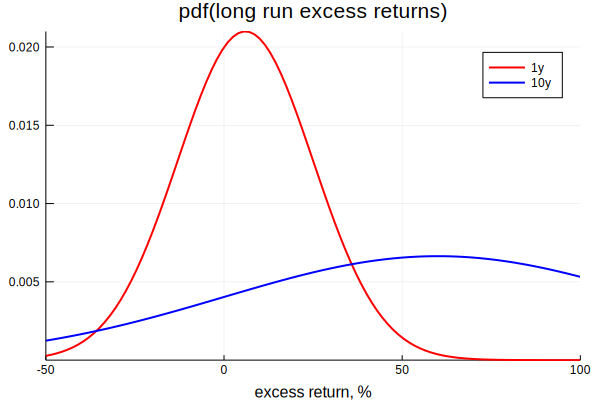

In [6]:
plot(Z,pdf_Z1y,color=:red,linewidth=2,label="1y")
plot!(Z,pdf_Z10y,color=:blue,linewidth=2,label="10y")
title!("pdf(long run excess returns)")
xlabel!("excess return, %")

##    Prob(Zᵉ < 0) for Different Horizons

In [7]:
t = 1:10

ProbNegReturn = fill(NaN,length(t))
for i in t
    ProbNegReturn[i] = ΦNS(0,i*μ,i*σ^2)    #cdf(0) for different horizons
end

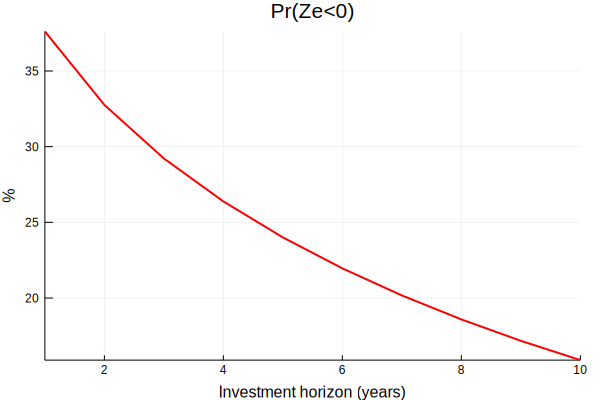

In [8]:
plot(t,ProbNegReturn*100,color=:red,linewidth=2,legend=false)
title!("Pr(Ze<0)")
xlabel!("Investment horizon (years)")
ylabel!("%")

## E(Zᵉ|Zᵉ < 0) for Different Horizons

see lecture notes for details

In [9]:
t = 1:10

CondER = fill(NaN,length(t))
for i in t
    CondER[i] = i*μ - sqrt(i)*σ*ϕNS(-sqrt(i)*μ/σ)/ΦNS(-sqrt(i)*μ/σ)  
end

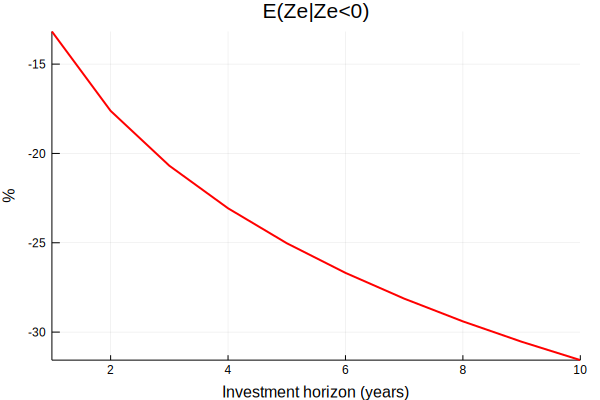

In [10]:
plot(t,CondER,color=:red,linewidth=2,legend=false)
title!("E(Ze|Ze<0)")
xlabel!("Investment horizon (years)")
ylabel!("%")